In [2]:
# Importieren der benötigten Libraries
import numpy as np
from sklearn.model_selection import train_test_split as sklearn_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.base import BaseEstimator
from sklearn.model_selection import (
    LeaveOneOut,
    LeavePOut,
    RepeatedStratifiedKFold,
    StratifiedShuffleSplit,
    StratifiedKFold,
    cross_validate,
    _split
)
from sklearn.datasets import make_classification, load_iris
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from matplotlib.colors import ListedColormap
from rich.console import Console
from rich.table import Table
from sklearn.metrics import mean_squared_error as mse

In [3]:
# Datensatz erstellen bestehend aus Datenpunkten X und Labels y
X, y = make_classification(
        n_samples=20,
        n_features=2,
        n_redundant=0,
        class_sep=1.0,
        n_clusters_per_class=1,
        random_state=5,
)

In [4]:
# 20 Datenpunkt mit jeweils zwei Features
print('Dimension: ', X.shape)
print(f"targets == {y.shape}")
print('Die ersten fünf Beispiele:\n', X[:5])

Dimension:  (20, 2)
targets == (20,)
Die ersten fünf Beispiele:
 [[-0.53026836 -1.71694547]
 [ 0.31395905  0.00812714]
 [ 1.5000949  -0.31824836]
 [-0.99673975 -1.44778459]
 [-1.369432   -0.79570873]]


## Hilfsmethoden

In [5]:
# Split Visualisierungsmethode
def plot_split_dataset(
    X_train: np.ndarray, X_test: np.ndarray, y_train: np.ndarray, y_test: np.ndarray
) -> None:
    plt.scatter(*X_train[y_train == 0].T, marker="x", color="lightblue", label="Class 0, Train")
    plt.scatter(*X_train[y_train == 1].T, marker="o", color="lightblue", label="Class 1, Train")
    plt.scatter(*X_test[y_test == 0].T, marker="x", color="orange", label="Class 0, Test")
    plt.scatter(*X_test[y_test == 1].T, marker="o", color="orange", label="Class 1, Test")

    handles = [mlines.Line2D([], [], color="black", marker=marker, linestyle="None", markersize=6, label=f"Class {c}")
               for c, marker in zip([0, 1], ["x", "o"])]
    handles.extend([mlines.Line2D([], [], color=color, marker=".", linestyle="None", markersize=6, label=label)
                    for color, label in zip(["lightblue", "orange"], ["Train", "Test"])])

    plt.legend(handles=handles, loc="upper right")

    plt.xlabel("$X_1$")
    plt.ylabel("$X_2$")
    plt.title("Zwei-Klassen Dataset Split von Train- und Testsatz")
    plt.show()

def plot_iris_dataset(X: np.ndarray, y: np.ndarray) -> None:
    cmap_bold = ListedColormap(["#FF0000", "#00FF00", "#0000FF"])
    plt.figure()
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolors="k")
    plt.title("Reduziertes Iris Dataset")
    plt.xlabel("Kelchblattbreite")
    plt.ylabel("Kelchblattlänge")
    plt.show()

# Trainiert ein Classifier und berechnet die Genaugikeit
def fit_and_score(
    clf: BaseEstimator,
    X_train: np.ndarray,
    X_test: np.ndarray,
    y_train: np.ndarray,
    y_test: np.ndarray,
) -> tuple[float, float]:
    clf.fit(X_train, y_train)
    
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    
    acc_train = accuracy_score(y_train, y_train_pred)
    acc_test = accuracy_score(y_test, y_test_pred)
    return acc_test, acc_train

# Gibt das Trainings/Evaluierungsergebnis auf der Ausgabe aus
def print_table(console: Console, name: str, mean_train: float,mean_test: float):
    table = Table(title=f"{name: <21}")
    table.add_column("Train Accuracy Mean")
    table.add_column("Test Accuracy Mean")
    table.add_row(f"{mean_train * 100:3.2f} %", f"{mean_test * 100:3.2f} %")
    console.print(table)

cache = {}

def plot_decision_boundary(
    model: KNeighborsClassifier, X: np.ndarray, y: np.ndarray
) -> None:
    h = 0.05  # step size in the mesh

    # Create color maps
    cmap_light = ListedColormap(["#FFAAAA", "#AAFFAA", "#AAAAFF"])
    cmap_bold = ListedColormap(["#FF0000", "#00FF00", "#0000FF"])

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    k = model.n_neighbors
    if k in cache:
        Z = cache[k]
    else:
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        cache[k] = Z

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor="k", s=20)
    plt.title("2D Iris KNN Decision Boundaries ($k=%s$)" % k)

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()


# Linear Regression Helper

def plot_polyfit(x_train, y_train, x_test, y_test, y_pred, degree, test_error):
    """Plottet eine angepasste Polynom-Regression Kurve."""
    plt.title(f"d = {degree}, test-mse = {test_error:2.3f}")
    plt.plot(x_test, y_pred, c="r", label="Polynom-Regression")
    plt.plot(x_test, y_test, c="g", label="$\sin(2\pi x)$")
    plt.scatter(x_train, y_train, label="Trainingsdaten")
    plt.ylim(-1.5, 1.5)
    plt.xlabel("x")
    plt.ylabel("y")

def plot_sin_curve(x_test, x_train, y_test, y_train):
    """Plottet eine Sinuskurve."""
    plt.figure()
    plt.scatter(x_train, y_train, label="Trainingsdaten")
    plt.plot(x_test, y_test, c="g", label="$\sin(2 \pi x)$")
    plt.legend()
    plt.show()

def plot_polynomial_fits(x_test, x_train, y_test, y_train):
    """Plottet Regressionskurven für verschiedene Grade."""
    # Plotten verschiedener Polynom-Regressionen
    plt.figure(figsize=(10, 4))
    for i, d in enumerate([0, 1, 5, 9]):
        plt.subplot(2, 2, i + 1)

        # Auswertung der Polynom-Regression mit Grad d
        error, y_pred = polynomial_regression(d, x_test, x_train, y_test, y_train)

        # Plotten der Kurve
        plot_polyfit(x_train, y_train, x_test, y_test, y_pred, d, error)
    plt.legend(bbox_to_anchor=(1.05, 0.85), loc=2, ncol=1)
    plt.tight_layout()
    plt.show()

def polynomial_regression(d, x_test, x_train, y_test, y_train):
    """Führt eine Polynom-Regression mit Grad d durch und gibt die Test-MSE und die Test-Y-Vorhersagen zurück."""
    # Abbilden der Trainings- und Testdaten auf den Polynomraum mit Grad d
    x_train_poly = map_polynomial(x_train, d)
    x_test_poly = map_polynomial(x_test, d)
    # Lineares Regressionsmodell im Polynomraum erstellen
    model = LinearRegression()
    model.fit(x_train_poly, y_train)
    # Vorhersagen berechnen
    y_pred = model.predict(x_test_poly)
    # Vorhersagen evaluieren
    test_error = mse(y_test, y_pred)
    return test_error, y_pred

## Aufgabe 2.1 Kreuzvalidierung

## b) Train-Test-Aufteilung
Implementieren Sie eine Methode `train_test_split` welche den Datensatz in 70% Trainingsmenge und 30% Testmenge aufteilt.
Initialisieren Sie hierfuer einen Zufalls-[Generator](https://numpy.org/doc/stable/reference/random/generator.html#numpy.random.Generator) `rng`.
Auf `rng` koennen Sie [Shuffle](https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.shuffle.html) oder [Choice](https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.choice.html) verwenden.

Sofern Sie diese Aufgabe nicht lösen können, verwenden Sie [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) von sklearn.

In [6]:
def train_test_split(
    X_data: np.ndarray, y_data: np.ndarray, test_size: float, seed: int = 2023
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Teilt die Daten in ein Train- und Testsatz. `test_size` gibt
    die Proportion des Testsatzes an
    """
    
    np.random.seed(seed)

    shuffled_indices = np.random.permutation(len(X_data))

    # create shuffled numpy arrays

    X_data_shuffled = X_data[shuffled_indices]
    y_data_shuffled = y_data[shuffled_indices]

    delimiter = int(len(y_data) * test_size)

    X_train = X_data_shuffled[delimiter:]
    y_train = y_data_shuffled[delimiter:]

    X_test = X_data_shuffled[:delimiter]
    y_test = y_data_shuffled[:delimiter] 


    return X_train, X_test, y_train, y_test

    

# Setzen der Testmenge
test_size=0.3

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=test_size)


In [7]:
print(y_test)

[1 0 0 0 1 0]


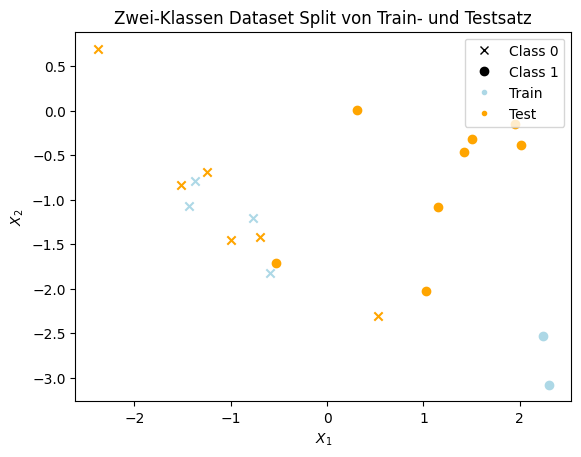

In [8]:
# Split Visualisierung
plot_split_dataset(X_test,X_train,y_test,y_train)

## e) Durchführung der Kreuzvalidierung
Implementieren Sie die Funktion `acc_kfold_cross_val`, um die gegebene Kreuzvalidierungsmethode
durchzuführen und die mittlere Trainings- und Testgenauigkeit zu errechnen. Verwenden Sie dabei die Methode
`sklearn.model_selection.cross_validate`

In [9]:
def acc_kfold_cross_val(
    clf: BaseEstimator,
    cv: _split._BaseKFold,
    X: np.ndarray,
    y: np.ndarray,
) -> tuple[float, float]:
    """Führt eine Kreuzvalidierung für den gegebenen Klassifizierer
    und die Kreuzvalidierungsmethode durch und gibt die durchschnittliche Trainings- und Testgenauigkeit zurück.
    """
    scores = cross_validate(estimator=clf,
                            X=X,
                            y=y,
                            cv=cv,
                            scoring=make_scorer(accuracy_score),
                            return_train_score=True)
    
    mean_acc_train = (scores["train_score"]).mean()
    mean_acc_test = (scores["test_score"]).mean()

    return mean_acc_train, mean_acc_test



In [10]:

# Definiert die Kreuzvalidierungsmethoden
cvs = [
    (StratifiedKFold(n_splits=10, shuffle=True, random_state=0), "KFold"),
    (
        RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=0),
        "Repeated KFold",
    ),
    (LeaveOneOut(), "Leave One Out"),
    (LeavePOut(p=5), "Leave P Out (p = 5)"),
    (
        StratifiedShuffleSplit(n_splits=10, test_size=0.33, random_state=0),
        "Shuffle Split",
    ),
]

# Output
console = Console()

# Classifiermodell
clf = DecisionTreeClassifier(random_state=0)

# Gibt die Genauigkeit fuer jede Method aus.
# 70/30 Split
mean_train, mean_test = fit_and_score(clf, X_train, X_test, y_train, y_test)
print_table(console, "70/30", mean_train, mean_test)
# Kreuzvalidierungsmethoden
for cv, name in cvs:
    mean_acc_train, mean_acc_test = acc_kfold_cross_val(clf, cv, X, y)
    print_table(console, name, mean_acc_train, mean_acc_test)



                   70/30                    
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Train Accuracy Mean ┃ Test Accuracy Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ 50.00 %             │ 100.00 %           │
└─────────────────────┴────────────────────┘

                   KFold                    
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Train Accuracy Mean ┃ Test Accuracy Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ 100.00 %            │ 80.00 %            │
└─────────────────────┴────────────────────┘

               Repeated KFold               
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Train Accuracy Mean ┃ Test Accuracy Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ 100.00 %            │ 81.00 %            │
└─────────────────────┴────────────────────┘

               Leave One Out                
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Train Accuracy Mean ┃ Test Accuracy Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ 100.00 %            │ 80.00 %            │
└─────────────────────┴────────────────────┘

            Leave P Out (p = 5)             
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Train Accuracy Mean ┃ Test Accuracy Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ 100.00 %            │ 78.86 %            │
└─────────────────────┴────────────────────┘

               Shuffle Split                
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Train Accuracy Mean ┃ Test Accuracy Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ 100.00 %            │ 77.14 %            │
└─────────────────────┴────────────────────┘

## Aufgabe 2.1 Kreuzvalidierung

### a) Vorverarbeitung des Datensatzes
In dieser Aufgabe verwenden wir einen Datensatz über Schwertlilien, bekannt als Iris-Dataset, welcher von dem
Biologen Ronald Fisher in dem Jahre 1936 veröffentlicht wurde. Wählen Sie die ersten beiden Merkmale (engl.
features): Kelchblattbreite (engl. sepal width) und Kelchblattlänge (engl. sepal length) über die Methode
`load_reduced_iris_dataset` aus. Den vollständigen Iris-Datensatz können Sie über die Funktion
[sklearn.datasets.load_iris](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html) laden.

In [ ]:
# Seed
np.random.seed(0)

In [37]:
def load_reduced_iris_dataset() -> tuple[np.ndarray, np.ndarray]:
    """Lädt den Iris-Datensatz, der auf seine ersten beiden Merkmale reduziert
    wurde (Kelchblattbreite, Kelchblattlänge)."""
    data = load_iris()

    sepal_features = data.data[:, :2]

    return sepal_features, data.target

X, y = load_reduced_iris_dataset()

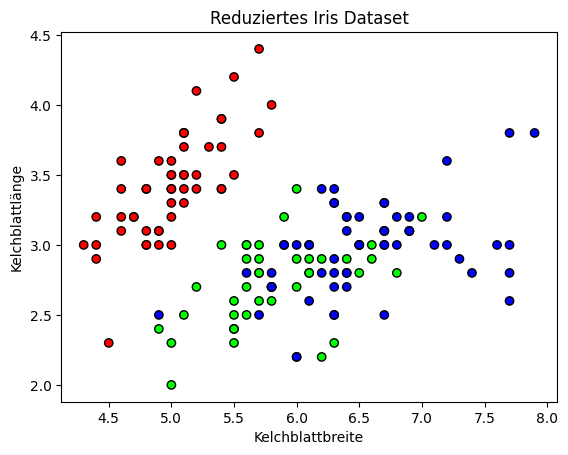

In [38]:
# Iris Visualisierung
plot_iris_dataset(X,y)

In [32]:
data = load_iris()
print(data.keys())
print(type(data.data[:,0]))
print(data.feature_names)
print(data.target)

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])
<class 'numpy.ndarray'>
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


### b) Evaluierung unterschiedlicher k-Werte
Der einzige und Hauptparameter von kNN ist die Anzahl, wie viele nächste Nachbarn eines Datenpunktes
entscheiden, welchem Label der Datenpunkt zugeordnet wird. Evaluieren Sie die Trainings- und Testgenauigkeit
für alle k-Werte k ∈ [1, 3, 5, . . . ,100] mittels der Funktion `evaluate_ks`. Verwenden Sie dabei die Methode
`evaluate` um eine Kreuzvalidierung mit 10 Splits für jeden K-Wert durchzuführen.

In [39]:
def evaluate(k: int, X: np.ndarray, y: np.ndarray) -> tuple[float, float]:
    """Führt eine 10-fache Kreuzvalidierung eines KNN-Modells
    durch und gibt die durchschnittliche Trainingsgenauigkeit
    und die durchschnittliche Testgenauigkeit zurück."""
    model = KNeighborsClassifier(n_neighbors=k)
    scores = cross_validate(
        estimator=model, X=X, y=y, scoring="accuracy", cv=10, return_train_score=True
    )
    return np.mean(scores["train_score"]), np.mean(scores["test_score"])

In [56]:
def evaluate_ks(
    ks: range, X: np.ndarray, y: np.ndarray
) -> tuple[np.ndarray, np.ndarray]:
    """Bewertet jeden k-Wert des ks-Arrays und gibt deren jeweilige Trainings- und Testgenauigkeit zurück."""
    acc_train =np.array([evaluate(k, X, y)[0] for k  in ks])
    acc_test =np.array([evaluate(k, X, y)[1] for k  in ks])

    return acc_train, acc_test



In [54]:
# Auswertung der Trainings und Testgenauigkeit fuer verschiedne K-Werte
ks = range(1, 100, 1)
acc_train, acc_test = evaluate_ks(ks, X, y)

In [57]:
acc_train.shape

(99,)

### c) Visualisierung der k-Werte
Visualisieren Sie die k-Werte gegenüber der Traings- und Testgenauigkeit in der Funktion `plot_k_to_acc`. Der
k-Wert wird auf die X-Achse und die Genauigkeit auf die Y-Achse abgebildet. Beschriften Sie ebenfalls beide
Achsen.

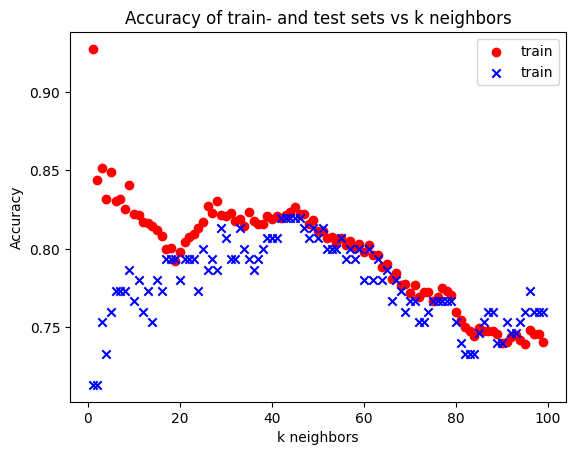

In [67]:
def plot_k_to_acc(ks: range, acc_train: np.ndarray, acc_test: np.ndarray) -> None:
    """Plottet die k-Werte in Relation zu ihrer jeweiligen Trainings- und
    Testgenauigkeit."""
    #raise NotImplementedError
    plt.figure()
    plt.scatter(ks, acc_train, c="r", marker="o", label="train")
    plt.scatter(ks, acc_test, c="b", marker="x", label="train")
    plt.xlabel("k neighbors")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy of train- and test sets vs k neighbors")
    plt.show()
plot_k_to_acc(ks, acc_train, acc_test)

### d) Bester k-Wert
Bestimmen Sie anhand der zuvor erhaltenen Zwischenergebnisse den besten k-Wert über die Funktion
`get_best_k`.

In [70]:
def get_best_k(ks: range, acc_test: np.ndarray) -> int:
    """Basierend auf der höchsten Testgenauigkeit gibt diese
    Funktion den besten Wert für k zurück."""
    #raise NotImplementedError
    index = acc_test.argmax()
    return ks[index]
    

get_best_k(ks, acc_test)

42

In [69]:
a = np.array([1, 2, 3, 88])
print(a.argmax())

3


### e) Entscheidungsregionen
Wir können auch die Entscheidungsregionen visualisieren, die ein kNN-Klassifikator für gegebene Werte von k
erstellt. Erzeugen Sie einen kNN-Klassifikator und stellen Sie dessen Entscheidungsregionen visuell in der
Methode `plot_decision_boundary_for_k` dar.

In [ ]:
def plot_decision_boundary_for_k(k: int, X: np.ndarray, y: np.ndarray) -> None:
    """Erstellt und passt ein KNN-Modell mit dem Wert k an und plottet
    dessen Entscheidungsgrenze."""
    raise NotImplementedError

for k in range(1, 101, 20):
        plot_decision_boundary_for_k(k, X, y)

## 2.3 Regression (Fortsetzung)

### b) Polynomiale Regression
Wir können die lineare Regression leicht auf nicht-lineare Eingangsvariablen-Zielvariablen-Korrelationen
ausdehnen. Daher ist es nur notwendig, unsere Eingabe in einen Merkmalsraum abzubilden, in dem die Merkmale
unserer Meinung nach linear mit der Zielvariablen korreliert sind. Ein gutes Beispiel ist die Polynomiale
Regression, die den Eingabedatenpunkt x nimmt und ihn auf den Satz polynomialer Merkmale (x0, x1, x2, . . . , xd)
abbildet, wobei d der Grad der Polynomtransformation ist.
Implementieren Sie die Funktion `map_polynomial`, welche diese Operation durchführt.

In [ ]:
def map_polynomial(x: np.ndarray, degree: int) -> np.ndarray:
    """Erstellt eine Polynomtransformation vom Grad d:
    Mapt jeden Datenpunkt x_i, x_(i+1), ..., x_k auf sein Polynom:
     [x_i, x_(i+1), ..., x_k] -> [[x_i^0,     ..., x_i^d],
                                  [x_(i+1)^0, ..., x_(i+1)^d],
                                              ....
                                  [x_k^0,     ..., x_k^d]]."""
    raise NotImplementedError

In [ ]:
# Wir definieren eine Funktion, welche Float-Zahlen ins Bogenmaß
# übersetzt und wenden diese auf den Sinus an.
def fsin(x: np.ndarray) -> np.ndarray:
  """Mappt eine Float-Zahl auf die ausgewertete Sinus-Funktion."""
  return np.sin(2 * np.pi * x)

# Daten Generierung
x_train = np.linspace(0, 1, 10).reshape(-1, 1)
y_train = fsin(x_train) + np.random.normal(scale=0.25, size=x_train.shape)
x_test = np.linspace(0, 1, 100).reshape(-1, 1)
y_test = fsin(x_test)

# Plotting
plot_sin_curve(x_test, x_train, y_test, y_train)
plot_polynomial_fits(x_test, x_train, y_test, y_train)